In [17]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [18]:
# Load data
df = pd.read_csv("../data/benin-malanville.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [19]:
# Summary
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


In [20]:
# Missing values
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_report = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
missing_report[missing_report['Percent'] > 5]

,Missing,Percent
Comments,525600,100.0


In [21]:
# Z-score outlier filtering
z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[z_cols].apply(zscore)
outlier_mask = (np.abs(z_scores) > 3)

In [22]:
# Drop rows with extreme values
df_clean = df[(~outlier_mask).all(axis=1)].copy()

In [23]:
df_clean.fillna(df_clean.median(numeric_only=True), inplace=True)

In [24]:
# Save cleaned version
import os
os.makedirs("../data", exist_ok=True)
df_clean.to_csv("../data/benin_clean.csv", index=False)

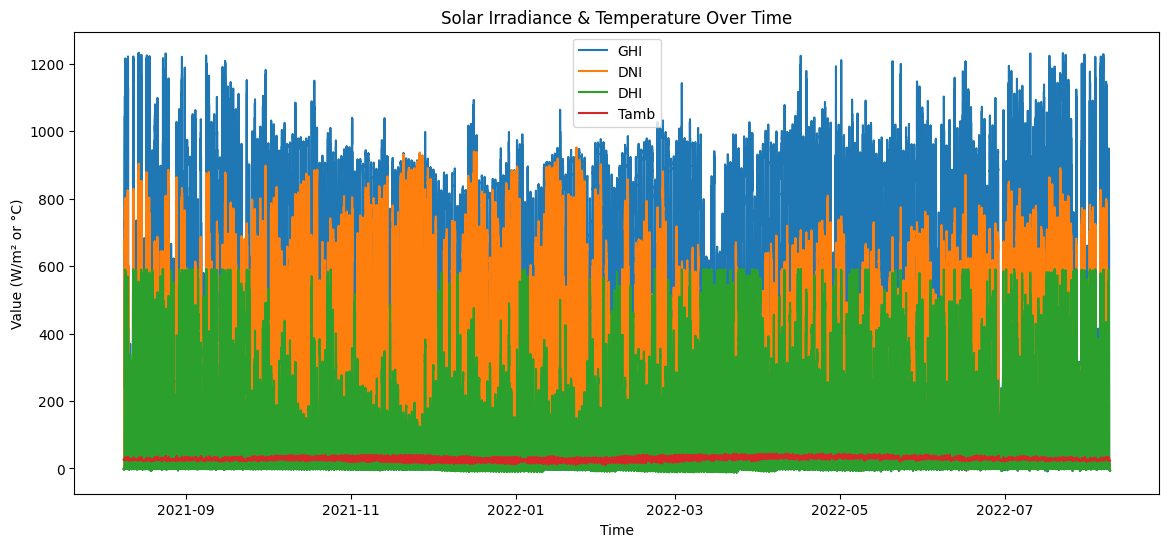

In [25]:
plt.figure(figsize=(14, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df_clean['Timestamp'], df_clean[col], label=col)
plt.legend()
plt.title("Solar Irradiance & Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Value (W/m² or °C)")
plt.show()

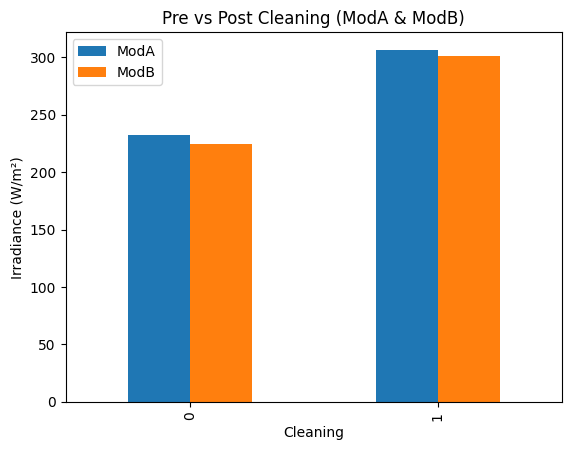

In [26]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
plt.title("Pre vs Post Cleaning (ModA & ModB)")
plt.ylabel("Irradiance (W/m²)")
plt.show()

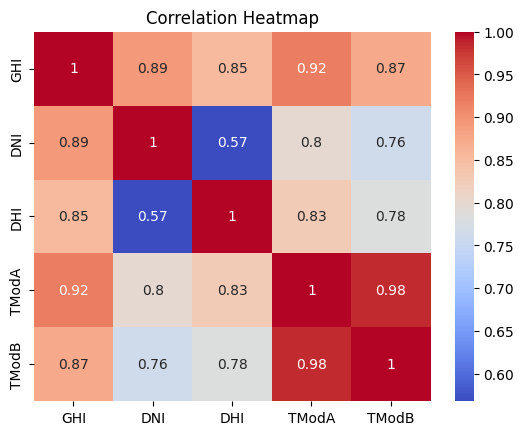

In [27]:
corr = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

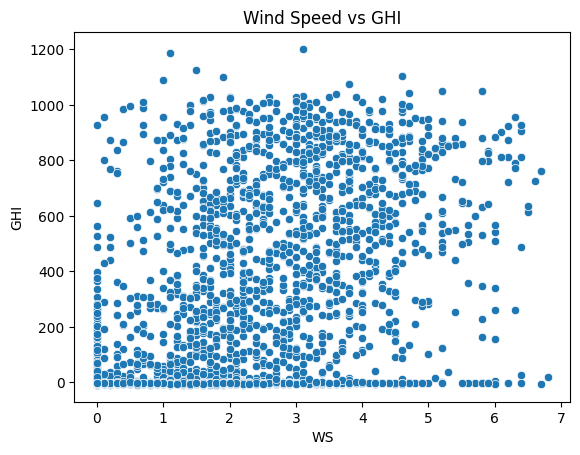

In [28]:
# Relationship: WS vs GHI
sns.scatterplot(data=df_clean.sample(3000), x='WS', y='GHI')
plt.title("Wind Speed vs GHI")
plt.show()

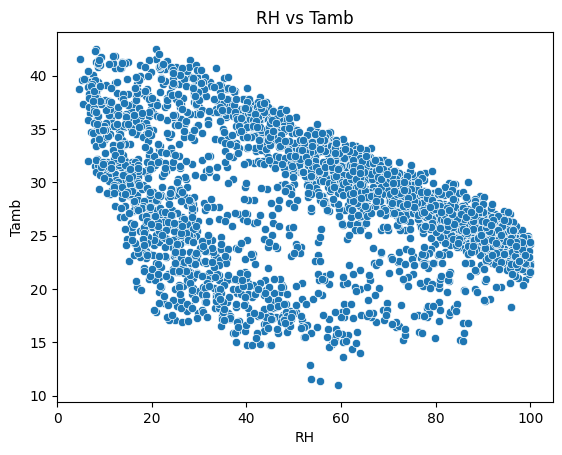

In [29]:
# Relationship: RH vs Tamb
sns.scatterplot(data=df_clean.sample(3000), x='RH', y='Tamb')
plt.title("RH vs Tamb")
plt.show()

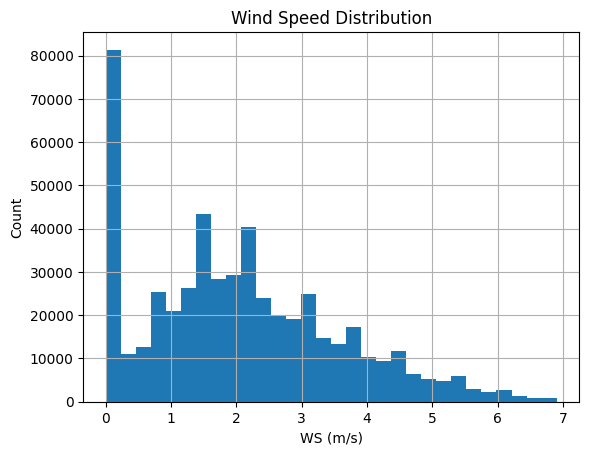

In [30]:
# Histogram of WS
df_clean['WS'].hist(bins=30)
plt.title("Wind Speed Distribution")
plt.xlabel("WS (m/s)")
plt.ylabel("Count")
plt.show()

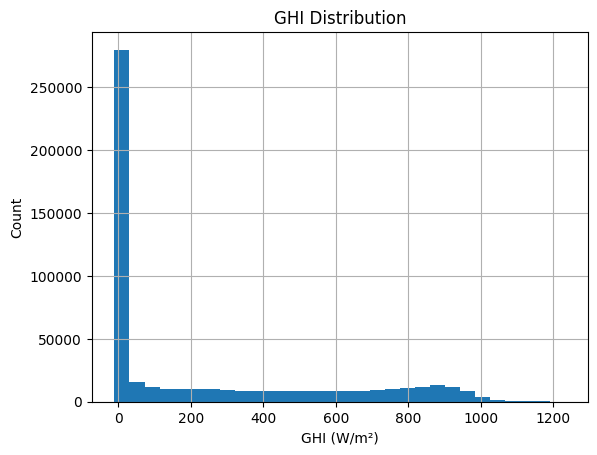

In [31]:
# Histogram of GHI
df_clean['GHI'].hist(bins=30)
plt.title("GHI Distribution")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Count")
plt.show()

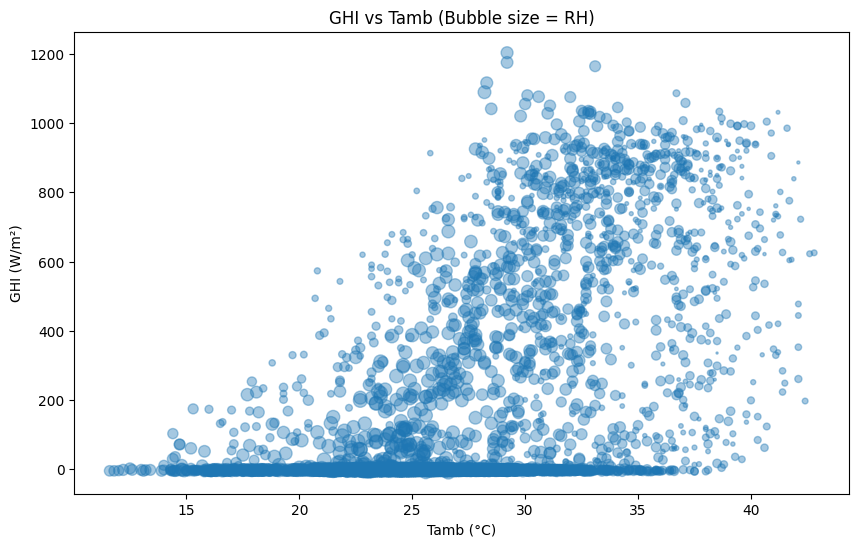

In [32]:
# GHI vs Tamb, Bubble Size = RH
sample = df_clean.sample(3000)
plt.figure(figsize=(10, 6))
plt.scatter(sample['Tamb'], sample['GHI'], s=sample['RH'], alpha=0.4)
plt.title("GHI vs Tamb (Bubble size = RH)")
plt.xlabel("Tamb (°C)")
plt.ylabel("GHI (W/m²)")
plt.show()

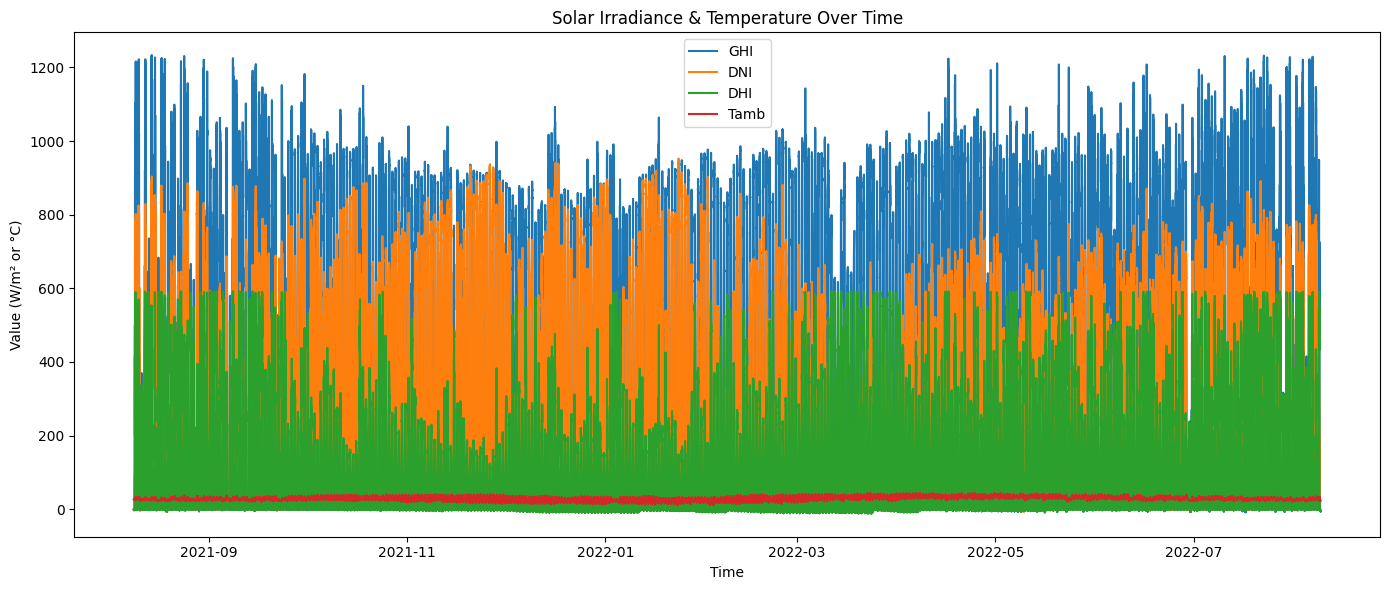

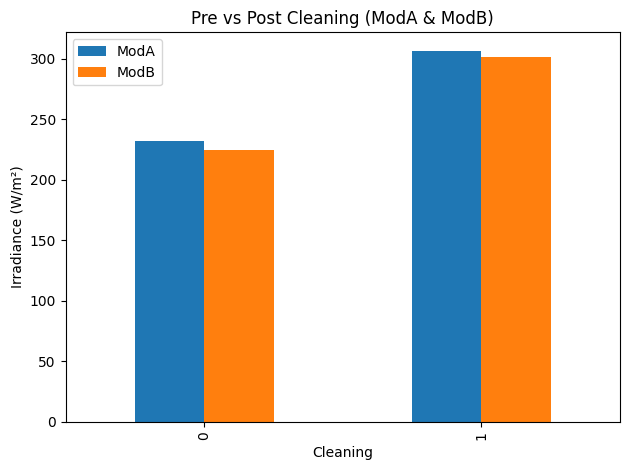

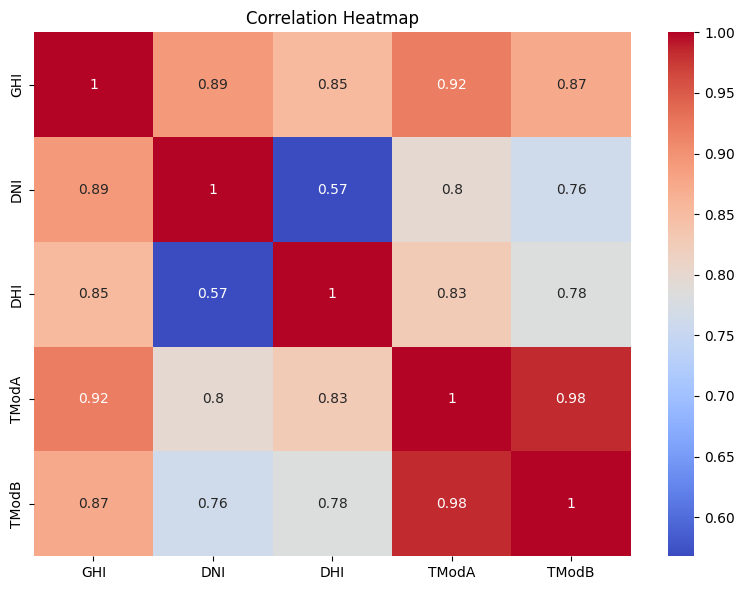

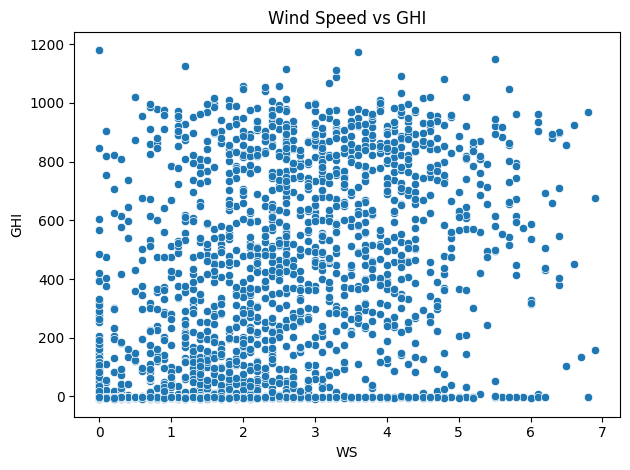

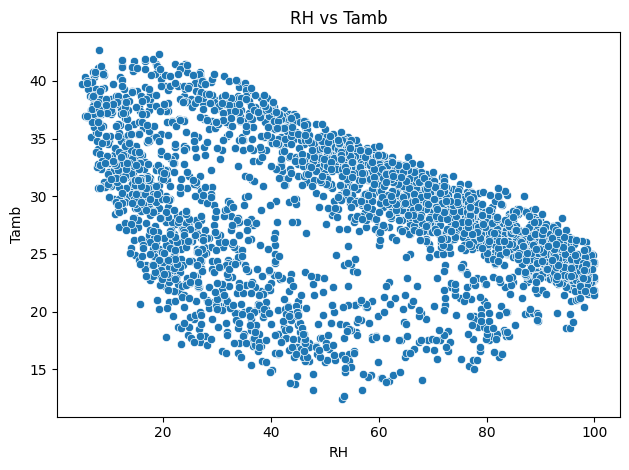

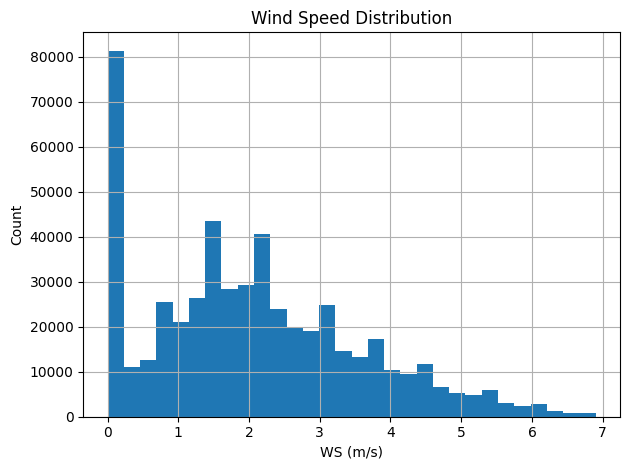

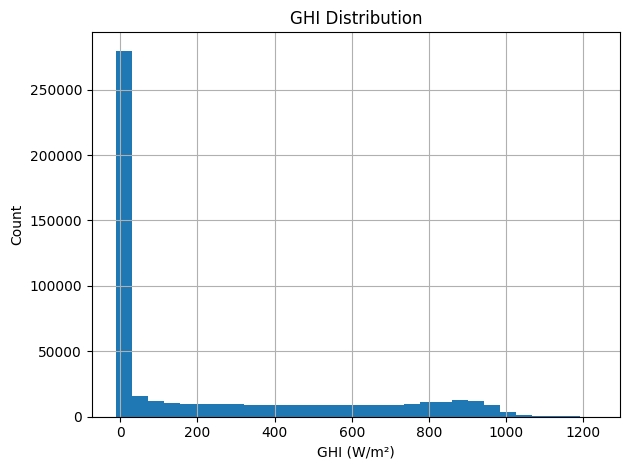

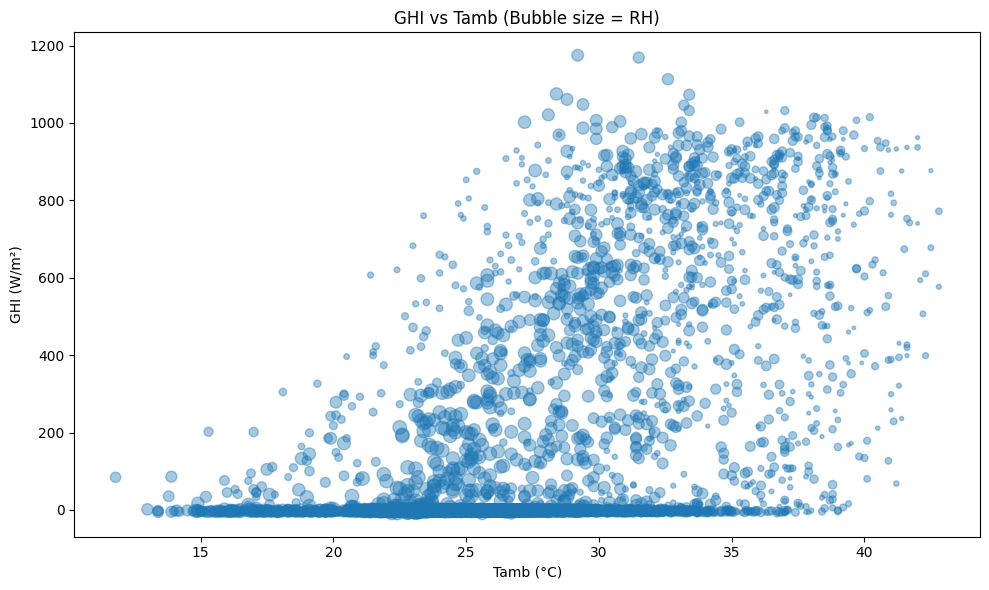

In [33]:
# Saving Images
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create figures directory if not exists
os.makedirs("../figures", exist_ok=True)

# --- Time Series Plot ---
plt.figure(figsize=(14, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df_clean['Timestamp'], df_clean[col], label=col)
plt.legend()
plt.title("Solar Irradiance & Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Value (W/m² or °C)")
plt.tight_layout()
plt.savefig("../figures/benin_timeseries.png")
plt.show()

# --- Cleaning Impact ---
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
plt.title("Pre vs Post Cleaning (ModA & ModB)")
plt.ylabel("Irradiance (W/m²)")
plt.tight_layout()
plt.savefig("../figures/benin_cleaning_impact.png")
plt.show()

# --- Correlation Heatmap ---
corr = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("../figures/benin_correlation_heatmap.png")
plt.show()

# --- WS vs GHI Scatter ---
plt.figure()
sns.scatterplot(data=df_clean.sample(3000), x='WS', y='GHI')
plt.title("Wind Speed vs GHI")
plt.tight_layout()
plt.savefig("../figures/benin_ws_vs_ghi.png")
plt.show()

# --- RH vs Tamb Scatter ---
plt.figure()
sns.scatterplot(data=df_clean.sample(3000), x='RH', y='Tamb')
plt.title("RH vs Tamb")
plt.tight_layout()
plt.savefig("../figures/benin_rh_vs_tamb.png")
plt.show()

# --- Wind Speed Histogram ---
plt.figure()
df_clean['WS'].hist(bins=30)
plt.title("Wind Speed Distribution")
plt.xlabel("WS (m/s)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/benin_ws_histogram.png")
plt.show()

# --- GHI Histogram ---
plt.figure()
df_clean['GHI'].hist(bins=30)
plt.title("GHI Distribution")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/benin_ghi_histogram.png")
plt.show()

# --- Bubble Chart: GHI vs Tamb w/ RH Bubble Size ---
plt.figure(figsize=(10, 6))
sample = df_clean.sample(3000)
plt.scatter(sample['Tamb'], sample['GHI'], s=sample['RH'], alpha=0.4)
plt.title("GHI vs Tamb (Bubble size = RH)")
plt.xlabel("Tamb (°C)")
plt.ylabel("GHI (W/m²)")
plt.tight_layout()
plt.savefig("../figures/benin_bubble_ghi_tamb.png")
plt.show()